In [1]:
# Add the path to the slack-pack/code/ folder in order to be able to import nlp module
import sys, os

NLP_PATH = '/'.join(os.path.abspath('.').split('/')[:-1]) + '/'
sys.path.append(NLP_PATH)

### Visualizing Topics

In [2]:
%matplotlib inline
import cPickle as pk

#### Loading a saved window

In [4]:
with open('../nlp/data/windows/tech_stuff_30m.pk', 'rb') as f:
    WINDOW = pk.load(f)

In [5]:
WINDOW.report_topics()

Window has #7 topics

Topic length report:
  Topic # 0  --> size: 10 
  Topic # 1  --> size: 6  
  Topic # 2  --> size: 1  
  Topic # 3  --> size: 10 
  Topic # 4  --> size: 2  
  Topic # 5  --> size: 1  
  Topic # 6  --> size: 1  


Perfect, now let's get a-viz-ing!



### Wordcloud

In [6]:
from nlp.models.summarization import TFIDF
from nlp.viz import cloud as nv
from nlp.grammar import tokenizer as nt

In [7]:
model = TFIDF(window=WINDOW, cleaner=nt.SimpleCleaner())

In [8]:
FONT_PATH = '../nlp/data/font/Ranga-Regular.ttf'
IMG_FOLDER = '../nlp/data/img/'

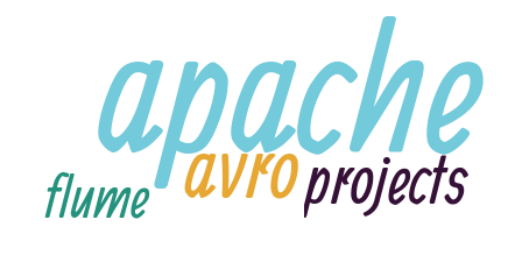

In [9]:
wordcloud = nv.Wordcloud(model, 2, max_words=10, font=FONT_PATH)  # defaults to 10 words
wordcloud.show()
wordcloud.save_png(IMG_FOLDER + 'apache_styled.png')

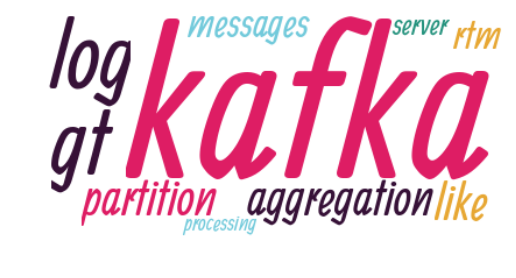

In [10]:
other_wordcloud = nv.Wordcloud(model, 3, max_words=10, font=FONT_PATH)
other_wordcloud.show()
other_wordcloud.save_png(IMG_FOLDER + 'kafka_styled.png')

#### Saving the wordcloud

In [28]:
IMG_FOLDER = '../nlp/data/img/'
wordcloud.save_png(IMG_FOLDER + 'new_wordcld.png')

In [30]:
other_wordcloud.save_png(IMG_FOLDER + 'nice_wordcld.png')

### N-Gram Wordclouds

We are going to create two wordclouds:  
* Bigram Wordcloud
* Trigram Wordlcoud

In [201]:
from nlp.viz.cloud import Wordcloud

In [206]:
bi_model = TFIDF(window=WINDOW, cleaner=nt.SimpleCleaner(), n_grams=2)

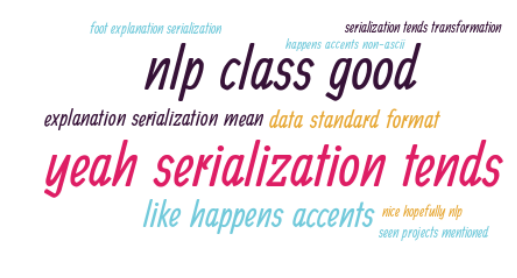

In [221]:
wc = Wordcloud(tri_model, 0, font='../nlp/data/font/Ranga-Regular.ttf')
wc.save_png(IMG_FOLDER + 'trigram_good.png')
wc.show()

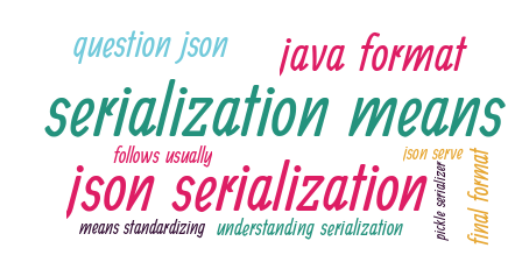

In [207]:
wc2 = Wordcloud(bi_model, 1, font='../nlp/data/font/Ranga-Regular.ttf')
wc2.show()

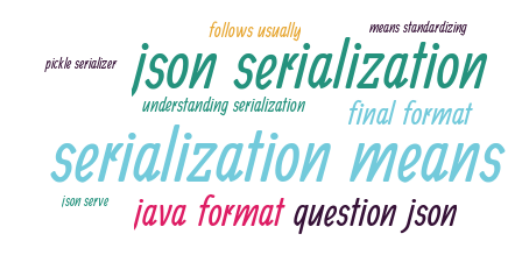

In [222]:
wc3 = Wordcloud(bi_model, 1, font='../nlp/data/font/Ranga-Regular.ttf')
wc3.save_png(IMG_FOLDER + 'bigram_good.png')
wc3.show()

### N-Gram Graphs

__This area is still under development__

In [188]:
from collections import defaultdict
from itertools import combinations
import numpy as np

from nlp.grammar import tokenizer as nt

import networkx as nx
import matplotlib.pyplot as plt

In [81]:
for c in combinations([], 2):
    print c

In [51]:
tri_model = TFIDF(window=WINDOW, cleaner=nt.SimpleCleaner(), n_grams=3)

In [103]:
trigrams_in_doc = map( lambda x: tri_model.n_gram_corpus.dictionary.get(x[0]), tri_model.n_gram_corpus.corpus[3] )
reverse_uni_dict = { v:k for k,v in tri_model.uni_corpus.dictionary.iteritems() }
codified_trigrams = map( lambda x: [ reverse_uni_dict[w] for w in x.split() ], trigrams_in_doc)

In [172]:
TOPIC_ID = 3
NUM_TRIGRAMS = 8


# Get NODES
ALL_NODES = map( lambda x: x[0], tri_model.uni_corpus.corpus[ TOPIC_ID ] )
TOP_NODES = set()
weights = defaultdict(lambda: 0)

for trg, sc in tri_model.get_top_terms(document_id=TOPIC_ID, top=NUM_TRIGRAMS):
    for w in trg.split():
        TOP_NODES.add( reverse_uni_dict[w] )
        weights[w] += sc

TOP_NODES = list(TOP_NODES)
TOP_NODES_WEIGHTS = map( lambda x: weights[tri_model.uni_corpus.dictionary.get(x)] , TOP_NODES )
TOP_NODES_WEIGHTS = map( lambda x: x / max(TOP_NODES_WEIGHTS), TOP_NODES_WEIGHTS )  # make them between 0-1
TOP_NODES_INTS = map( lambda x: int(100. * x / min(TOP_NODES_WEIGHTS) ), TOP_NODES_WEIGHTS )  # make them ints

# Get EDGES
EDGES = defaultdict( lambda: 0 )
for trigram in codified_trigrams:
    pairs = combinations( filter(lambda x: x in TOP_NODES, trigram), 2 )
    for a,b in pairs:
        if a != b:
            a, b = min(a,b), max(a,b)  # always define EDGES by low-high
            EDGES[(a,b)] += 1    
            
            
# Create NETWORK GRAPH
gr = nx.Graph()

for nd in TOP_NODES:
    gr.add_node(nd)

for ed in EDGES.iterkeys():
    gr.add_edge(ed[0], ed[1])

labels={}

for w in TOP_NODES:
    labels[w] = tri_model.uni_corpus.dictionary.get(w)

In [173]:
min_font, max_font = 10, 20

rescale = lambda x: min_font + (max_font - min_font)*(x - min(TOP_NODES_INTS))/(max(TOP_NODES_INTS)-min(TOP_NODES_INTS))

FONT_SIZES = map( rescale , TOP_NODES_INTS )

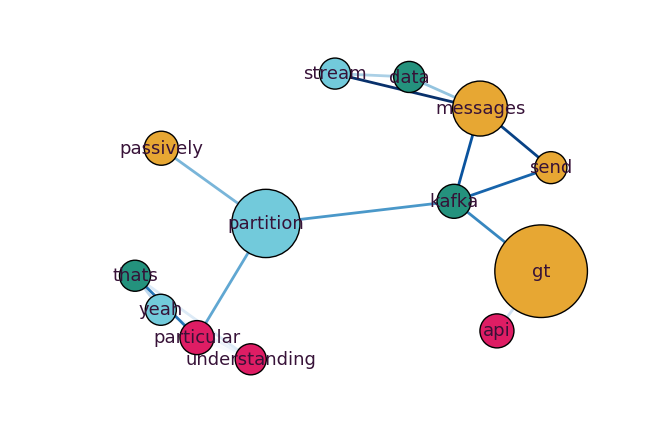

In [200]:
COLORS = np.random.choice(["#DE1D64","#24927D","#72CADB","#E7A733"], size=len(gr.nodes()), replace=True)

SIZES = [ x*5 for x in TOP_NODES_INTS ]


# pos=nx.spring_layout(gr)
# pos = nx.circular_layout(gr)
# pos = nx.shell_layout(gr)

pos=nx.fruchterman_reingold_layout(gr)

colors = range( len(gr.edges()) )

nx.draw(gr, pos, node_size=1, edge_color=colors, width=2, edge_cmap=plt.cm.Blues)

nx.draw_networkx_nodes(gr, pos,
                       nodelist=TOP_NODES,
                       node_size=SIZES,
                       node_color=COLORS,
                       label=labels )

nx.draw_networkx_labels(gr, pos, labels, font_size=13, font_color='#361137')
plt.savefig(IMG_FOLDER + 'graph_kafka.png')
plt.show()

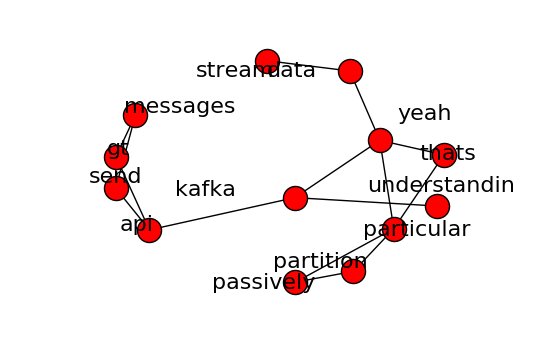

In [97]:
nx.draw_networkx_labels(gr,nx.spring_layout(gr),labels,font_size=16)

nx.draw(gr)
# plt.savefig("simple_path.png") # save as png
plt.show() # display